In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr

# Загрузка и предобработка данных

In [2]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume  # convert volume from lots to money

prices, pe, volume = pqr.utils.replace_with_nan(prices, pe, volume)

# Строим фактор стоимости и бенчмарк

In [3]:
universe = volume >= 1_000_000
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

In [5]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_mean, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)
value = mean_transform(pe)

# Конструируем портфель из 50% лучших по фактору стоимости компаний

,Top 50%
"Monthly Mean Return, %",1.59*** (3.17)
"Monthly Volatility, %",7.44
"Maximum Drawdown, %",-66.87
"Monthly Mean Excess Return, %",0.19 (1.02)
"Monthly Alpha, %",0.20 (1.06)
"Monthly Beta, %",0.99*** (36.55)


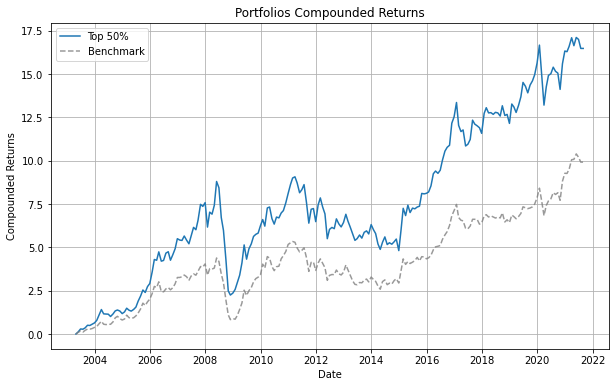

In [6]:
portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value, 0, 0.5),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Top 50%"
)

summary.display([portfolio])

# Пробуем поскейлить

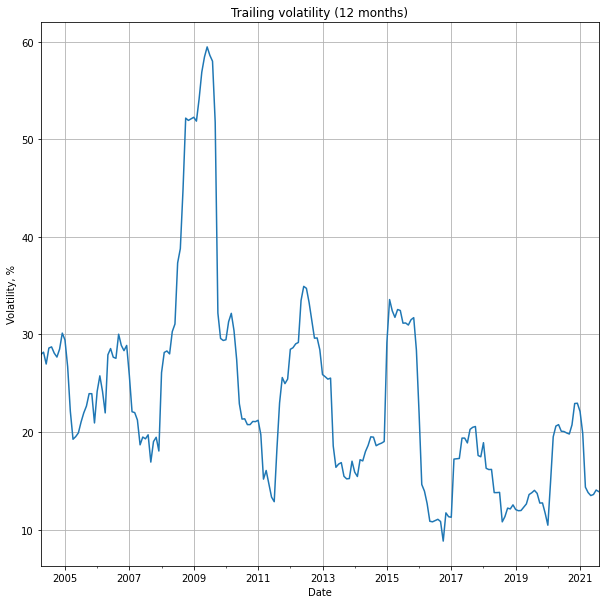

In [7]:
(pqr.metrics.trailing_volatility(portfolio) * 100).plot(figsize=(10, 10))

plt.title("Trailing volatility (12 months)")
plt.xlabel("Date")
plt.ylabel("Volatility, %")
plt.grid();

Волатильность портфеля выглядит неплохо, но видно, что в периоды высокой волатильности (особенно 2008 г.) портфель проигрывает бенчмарку. Попробуем это исправить за счет скейлинга по волатильности.

In [8]:
def volatility_scaling(
    holdings: pd.DataFrame,
    prices: pd.DataFrame,
    target: float,
) -> pd.DataFrame:
    returns = pqr.calculate_returns(pqr.prices_to_returns(prices), holdings)
    volatility = pqr.metrics.trailing_volatility(returns)
    w, vol = pqr.utils.align(holdings, volatility)
    vol_df = pd.DataFrame(
        np.ones_like(w) * vol.to_numpy()[:, np.newaxis],
        index=w.index,
        columns=w.columns,
    )
    
    return pqr.scale(
        holdings,
        base_leverage=vol_df,
        target=target,
    )

In [9]:
portfolio_scaled = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value, 0, 0.5),
    shorts=None,
    allocator=pqr.utils.compose(
        pqr.equal_weights,
        pqr.utils.partial(
            volatility_scaling,
            prices=prices,
            target=0.2,
        )
    ),
    calculator=returns_calculator,
    name="Top 50% (scaled)",
)

Посмотрим на получившееся плечо портфеля.

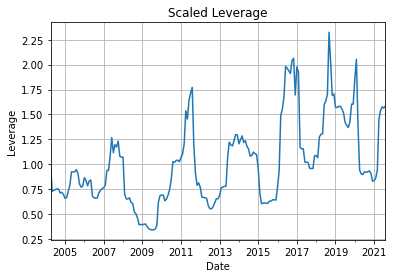

In [10]:
portfolio_scaled.holdings.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

,Top 50%,Top 50% (scaled)
"Monthly Mean Return, %",1.59*** (3.17),1.10** (2.30)
"Monthly Volatility, %",7.44,6.95
"Maximum Drawdown, %",-66.87,-51.19
"Monthly Mean Excess Return, %",0.19 (1.02),-0.03 (-0.09)
"Monthly Alpha, %",0.20 (1.06),0.17 (0.62)
"Monthly Beta, %",0.99*** (36.55),0.82*** (21.01)


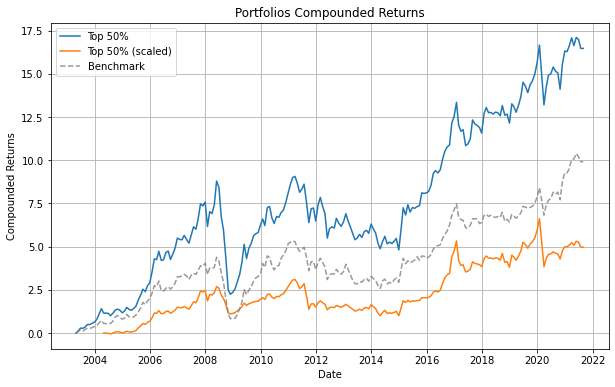

In [11]:
summary.display([portfolio, portfolio_scaled])

Стало хуже, потому что в 2008 году пришлось понижать плечо слишком поздно, за счет чего не был пойман отскок рынка (зато падение поймали отлично), а в 2017 году на экстремально низкой волатильности портфеля было повышено плечо очень сильно, что привело к большим потерям. Попробуем ограничить плечо.

In [12]:
portfolio_scaled_limits = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value, 0, 0.5),
    shorts=None,
    allocator=pqr.utils.compose(
        pqr.equal_weights,
        pqr.utils.partial(
            volatility_scaling,
            prices=prices,
            target=0.2,
        ),
        pqr.utils.partial(
            pqr.limit_leverage,
            min_leverage=0.8,
            max_leverage=1.5,
        )
    ),
    calculator=returns_calculator,
    name="Top 50% (scaled with limits)",
)

Видно, что теперь не позволяем портфелю быть заполненным менее чем на 80%, но плечо ограничиваем в 1.2

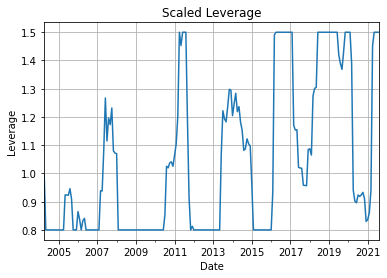

In [13]:
portfolio_scaled_limits.holdings.sum(axis=1).plot()

plt.title("Scaled Leverage")
plt.xlabel("Date")
plt.ylabel("Leverage")
plt.grid();

Но сильно лучше не стало: хотя в 2017 ушла такая бешеная волатильность портфеля, после 2008 оставание никуда не делось.

,Top 50%,Top 50% (scaled),Top 50% (scaled with limits)
"Monthly Mean Return, %",1.59*** (3.17),1.10** (2.30),1.22*** (2.47)
"Monthly Volatility, %",7.44,6.95,7.15
"Maximum Drawdown, %",-66.87,-51.19,-57.57
"Monthly Mean Excess Return, %",0.19 (1.02),-0.03 (-0.09),0.09 (0.42)
"Monthly Alpha, %",0.20 (1.06),0.17 (0.62),0.17 (0.79)
"Monthly Beta, %",0.99*** (36.55),0.82*** (21.01),0.93*** (30.25)


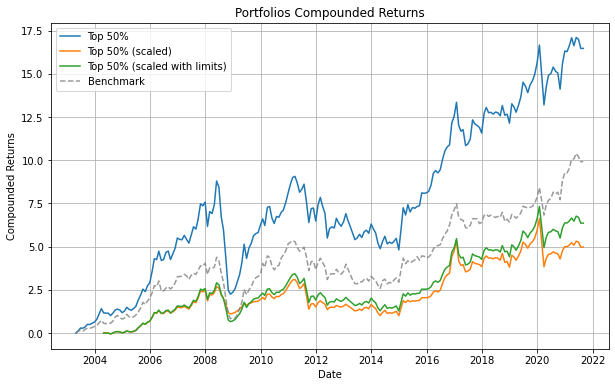

In [14]:
summary.display([portfolio, portfolio_scaled, portfolio_scaled_limits])